# R-CNN
整合前面训练好的模型, 并在测试集和验证集中计算mAP

In [1]:
import os
import cv2
import matplotlib.pyplot as plt
import tensorflow as tf
import numpy as np
import selectivesearch
import matplotlib.patches as mpatches
import itertools
from tensorflow.keras import Sequential, layers, Model, models
from tensorflow.keras import regularizers
import sklearn.svm as svm
from scipy.special import expit

## 1. 加载fine-tuning的AlexNet
这里只需要提取特征, 所以pop掉最后一层

In [2]:
alex_dir = "./AlexNet_fine_tuning_pascal"
alex_net = tf.keras.models.load_model(alex_dir)
for i in range(1):  # pop掉最后一层
    alex_net.pop()

In [3]:
alex_net.summary()  # 这个模型不会保存trainable的信息

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv_1 (Conv2D)              multiple                  34944     
_________________________________________________________________
pool_1 (MaxPooling2D)        multiple                  0         
_________________________________________________________________
bn_1 (BatchNormalization)    multiple                  384       
_________________________________________________________________
conv_2 (Conv2D)              multiple                  614656    
_________________________________________________________________
pool_2 (MaxPooling2D)        multiple                  0         
_________________________________________________________________
bn_2 (BatchNormalization)    multiple                  1024      
_________________________________________________________________
conv_3 (Conv2D)              multiple                  8

## 2. 加载训练好的svm

In [4]:
# 保存模型
import joblib
svm_dir = "./svm_pascal.pkl"
svm = joblib.load(svm_dir)
print(svm)

SVC(class_weight='balanced')


# 3. 加载数据集

In [5]:
# 创建一个描述器
image_feature_description = {
    'image_raw': tf.io.FixedLenFeature([], tf.string),
    'bboxes': tf.io.FixedLenSequenceFeature([4], tf.float32, allow_missing=True),  # 用float存的原因是方便后面归一化, 也可以在存之前就归一化
    'labels': tf.io.FixedLenSequenceFeature([], tf.int64, allow_missing=True),
    'labels_text': tf.io.FixedLenSequenceFeature([], tf.string, allow_missing=True),
    'image_name': tf.io.FixedLenFeature([], tf.string),
    'regions': tf.io.FixedLenSequenceFeature([4], tf.float32, allow_missing=True),
    'regions_label':tf.io.FixedLenSequenceFeature([], tf.int64, allow_missing=True)
}
def parse_image_function(example_proto):
    # 把Example转为dict
    return tf.io.parse_single_example(example_proto, image_feature_description)

In [6]:
def preprocess(image_raw, bboxes, regions):
    region_datas = []
    img = tf.image.decode_jpeg(image_raw)
    for region in regions:
        # 按照regions切割原图像
        region = tf.cast(region, tf.int64)
        xmin, ymin, xmax, ymax = region
        region_data = img[ymin: ymax, xmin: xmax, :]
        region_data = tf.cast(region_data, tf.float32)
        region_data = tf.image.resize(region_data, [32, 32])  # warp
        region_data = region_data
        region_datas.append(region_data)
    return tf.convert_to_tensor(region_datas), bboxes, tf.cast(img, tf.float32), regions

In [7]:
def _ensure_shape(region_datas, regions_label):
    return tf.ensure_shape(region_datas, [32, 32, 3]), tf.ensure_shape(regions_label, [])

In [8]:
def _etract_features(regions_raw, bboxes, img, regions):
    return (alex_net(regions_raw), bboxes, img, regions)

In [9]:
def _svm_predict(features, regions_label, img, regions):
    return expit(svm.decision_function(features)), regions_label, img, regions

In [10]:
# 计算IOU
def _iou(bbox1, bbox2):
    ymin_1, xmin_1, ymax_1, xmax_1 = bbox1
    ymin_2, xmin_2, ymax_2, xmax_2 = bbox2
    bxmin = max(xmin_1, xmin_2)
    bymin = max(ymin_1, ymin_2)
    bxmax = min(xmax_1, xmax_2)
    bymax = min(ymax_1, ymax_2)
    bwidth = max(bxmax - bxmin, 0)
    bheight = max(bymax - bymin, 0)
    inter = bwidth * bheight
    union = (xmax_1 - xmin_1) * (ymax_1 - ymin_1) + (xmax_2 - xmin_2) * (ymax_2 - ymin_2) - inter
    return inter / union

## train数据集

In [11]:
out_dir = r".\data\PASCAL_VOC_2007_OBJ_car_train_regions.tfrecords"
ds = tf.data.TFRecordDataset(out_dir).map(parse_image_function)

In [12]:
ds_train = ds.map(lambda x: (x["image_raw"], x["bboxes"], x["regions"]))  \
                .map(lambda image_raw, bboxes, regions: tf.py_function(func=preprocess,
                            inp=[image_raw, bboxes, regions], Tout = [tf.float32, tf.float32, tf.float32, tf.float32])) \
                .map(lambda regions_raw, bboxes, img, regions: tf.py_function(func = _etract_features,
                                                                        inp = [regions_raw, bboxes, img, regions],
                                                                        Tout = [tf.float32, tf.float32, tf.float32, tf.float32])) \
                .map(lambda features, bboxes, img, regions: tf.py_function(func = _svm_predict,
                                                                        inp = [features, bboxes, img, regions],
                                                                        Tout = [tf.float32, tf.float32, tf.float32, tf.float32]))

Cause: could not parse the source code:

                .map(lambda regions_raw, bboxes, img, regions: tf.py_function(func = _etract_features,
                                                                        inp = [regions_raw, bboxes, img, regions],
                                                                        Tout = [tf.float32, tf.float32, tf.float32, tf.float32])) \
                .map(lambda features, bboxes, img, regions: tf.py_function(func = _svm_predict,
                                                                        inp = [features, bboxes, img, regions],
                                                                        Tout = [tf.float32, tf.float32, tf.float32, tf.float32]))

This error may be avoided by creating the lambda in a standalone statement.

To silence this warning, decorate the function with @tf.autograph.experimental.do_not_convert
Cause: could not parse the source code:

                .map(lambda regions_raw, bboxes, img, regi

predict scores:  tf.Tensor([[150. 165. 252. 318.]], shape=(1, 4), dtype=float32)
predict bboxes: tf.Tensor([0.7921522], shape=(1,), dtype=float32)
bboxes: [[ 97. 156. 270. 351.]]


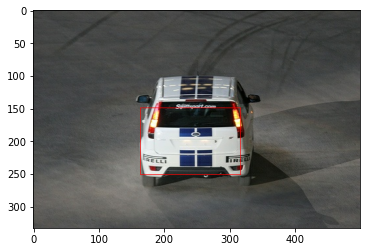

predict scores:  tf.Tensor([[125.  85. 212. 387.]], shape=(1, 4), dtype=float32)
predict bboxes: tf.Tensor([0.911996], shape=(1,), dtype=float32)
bboxes: [[125.  90. 212. 337.]]


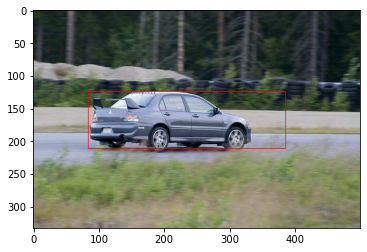

In [40]:
# 可视化出来看看预测的怎么样
for scores, bboxes, img, regions in ds_train.take(2):
    # 处理一下regions和bboxes, 因为TensorFlow要求输入为y1,x1,y2,x2
    regions = regions.numpy()
    bboxes = bboxes.numpy()
    regions[:, [0, 1]] = regions[:, [1, 0]]
    regions[:, [2, 3]]  = regions[:, [3, 2]]
    bboxes[:, [0, 1]] = bboxes[:, [1, 0]]
    bboxes[:, [2, 3]]  = bboxes[:, [3, 2]]
    img /= 255.
    
    selected_indices = tf.image.non_max_suppression(regions, scores, 1, score_threshold=0.5, iou_threshold = 0.3)
    selected_boxes = tf.gather(regions, selected_indices)
    print("predict scores: ", selected_boxes)
    print("predict bboxes:", tf.gather(scores, selected_indices))
    print("bboxes:", bboxes)
    
    height = img.shape[0]
    width = img.shape[1]
    selected_boxes = selected_boxes.numpy()    
    selected_boxes[:, [0, 2]] /= height
    selected_boxes[:, [1, 3]] /= width
    selected_boxes = tf.expand_dims(selected_boxes, 0)

    img = tf.expand_dims(img, 0)
    img = tf.image.draw_bounding_boxes(img, selected_boxes, np.array([[1.0, 0.0, 0.0]]))
    plt.imshow(tf.squeeze(img))
    plt.show()

In [71]:
def _non_max_suppression(scores, bboxes, img, regions):
    # 把scores和bboxes的x,y顺序换一下
    regions = tf.transpose(regions)
    rows = tf.gather(regions, [0, 1, 2, 3], axis=0)
    regions = tf.tensor_scatter_nd_update(regions,[[1], [0], [3], [2]], rows)
    regions = tf.transpose(regions)
    
    bboxes = tf.transpose(bboxes)
    rows = tf.gather(bboxes, [0, 1, 2, 3], axis=0)
    bboxes = tf.tensor_scatter_nd_update(bboxes,[[1], [0], [3], [2]], rows)
    bboxes = tf.transpose(bboxes)
    
    selected_indices = tf.image.non_max_suppression(regions, scores, 1, score_threshold = 0.5, iou_threshold = 0.3)
    selected_boxes = tf.gather(regions, selected_indices)
    selected_scores = tf.gather(scores, selected_indices)
    return selected_scores, bboxes, img, selected_boxes

In [72]:
score_threshold = 0.5

In [73]:
def _get_scores(selected_scores, bboxes, img, selected_boxes):
    tp = 0
    for idx, selected_box in enumerate(selected_boxes):
        if selected_scores[idx] < score_threshold:
            continue
        for bbox in bboxes:
            iou = _iou(selected_box, bbox)
            if iou >= 0.5:  # iou阈值选取为0.5
                tp += 1
                break  # 防止一个selected box与bbox重复比较
    num = len(selected_boxes) if len(selected_boxes) != 0 else 1 
    precision = tp / num
    recall = tp / len(bboxes)
    return (precision, recall)

In [74]:
ds_result = ds_train.map(_non_max_suppression).map(lambda selected_scores, bboxes, img, selected_boxes: tf.py_function(func = _get_scores,
                                                                        inp = [selected_scores, bboxes, img, selected_boxes],
                                                                        Tout = [tf.float32, tf.float32]))

### 4 计算AP

In [75]:
# 通过不断改变 score_threshold来计算AP
precisions = []
recalls = []
for threshold in np.linspace(0.5, 0.8, 3):
    global score_threshold
    score_threshold = threshold  # Tensorflow的流式编程只需要改变这里就可以得到不同置信度下的precision和recall
    num = 0
    sum_precision = 0
    sum_recall = 0
    for precision, recall in ds_result.take(10):
        num += 1
        sum_precision += precision
        sum_recall += recall
    avg_precision = sum_precision / num
    avg_recall = sum_recall / num
    precisions.append(avg_precision.numpy())
    recalls.append(avg_recall.numpy())
    print("======")
precisions = np.array(precisions)
recalls = np.array(recalls)

print(precisions)  # AP 大概在40%左右
print(recalls)

[0.4 0.4 0.4]
[0.3 0.3 0.3]
